In [9]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from ipywidgets import interact
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import register_keras_serializable

from Training_Data.Particle_Tracking_Training_Data import Particle_Tracking_Training_Data

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [10]:
from tensorflow.keras import models, layers

def particle_tracking_model(input_shape=(256, 256, 1), output_shape=(128, 128, 2)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.Conv2D(output_shape[2], (1, 1), activation='softmax', padding='same')
    ])
    return model

model = particle_tracking_model()

In [11]:
Nt = 100 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)

# 创建并查看模型结构
model = particle_tracking_model()
model.summary()

# 2. 生成一个随机输入 (batch_size=1, 256×256, 通道数=1)
frame_0 = tf.expand_dims(tf.expand_dims(vid[0], axis=0), axis=-1)
y1 = model(frame_0)
print("输入形状:", frame_0.shape)
print("输出形状:", y1.shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 64)    

In [12]:
X_curr = []
X_prev = []
Y_labels = []

for i in range(1, Nt):
    # 当前帧 shape (256,256,1)
    curr = tf.expand_dims(vid[i],   axis=-1)
    # 前一帧 shape (256,256,1)
    prev = tf.expand_dims(vid[i-1], axis=-1)

    X_curr.append(curr)
    X_prev.append(prev)

    Y_labels.append(labels[i])  # 对应当前帧的标签

X_curr = tf.stack(X_curr, axis=0)  # (Nt-1, 256,256,1)
X_prev = tf.stack(X_prev, axis=0)  # (Nt-1, 256,256,1)
Y_labels = tf.stack(Y_labels, axis=0)

In [13]:
class OneHotMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        # total_confusion_matrix 的形状为 [num_classes, num_classes]
        self.total_cm = self.add_weight(
            name='total_confusion_matrix',
            shape=(num_classes, num_classes),
            initializer='zeros',  # 或 tf.zeros_initializer()
            dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        y_true, y_pred: (batch, height, width, num_classes) 的 one-hot。
        这里先将 one-hot 转成整型类别索引，再更新混淆矩阵。
        """
        y_true_argmax = tf.argmax(y_true, axis=-1)
        y_pred_argmax = tf.argmax(y_pred, axis=-1)

        y_true_argmax = tf.reshape(y_true_argmax, [-1])
        y_pred_argmax = tf.reshape(y_pred_argmax, [-1])

        current_cm = tf.math.confusion_matrix(
            y_true_argmax,
            y_pred_argmax,
            num_classes=self.num_classes,
            weights=sample_weight,
            dtype=tf.float32
        )
        self.total_cm.assign_add(current_cm)

    def result(self):
        # mean IoU = average over (true_positives / union)
        sum_over_row = tf.reduce_sum(self.total_cm, axis=0)
        sum_over_col = tf.reduce_sum(self.total_cm, axis=1)
        true_positives = tf.linalg.diag_part(self.total_cm)
        denominator = sum_over_row + sum_over_col - true_positives
        iou = true_positives / denominator
        return tf.reduce_mean(iou)

    def reset_states(self):
        # 每个 epoch 前自动重置
        tf.keras.backend.batch_set_value(
            [(v, tf.zeros_like(v)) for v in self.variables]
        )


In [15]:
# Define loss function
from tensorflow.keras.utils import register_keras_serializable
#@register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred):
    """
    Weighted binary crossentropy loss, where the weight for class 1 (particles)
    is 300 times the weight for class 0 (background).
    """
    # Define weight
    weight_for_0 = 1.0 
    weight_for_1 = 300.0 
    
    # Compute weight tensor, with the same shape as y_true
    weights = tf.where(tf.equal(y_true[..., 1], 1), weight_for_1, weight_for_0)
    
    # Calculate binary crossentropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Apply weights
    weighted_bce = weights * bce
    
    # Return the mean of the weighted loss
    return tf.reduce_mean(weighted_bce)

In [16]:
# X_curr, X_prev, Y_labels 的第一维是 batch_size = (Nt-1), 
# 每一帧 shape = (256,256,1)，标签 shape = (128,128,2) 或 (256,256,2)

# 1. 定义指数衰减的学习率调度
initial_lr = 0.16
decay_rate = 0.95
decay_steps = 1000  # 每 1000 个 step 衰减一次，可根据数据大小和训练步数调整

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # 若为 True，则每到达 decay_steps 后才跳变；False 表示连续光滑衰减
)

# 2. 定义优化器为 SGD，并使用 lr_schedule 作为学习率
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

# 3. 编译模型
model.compile(
    optimizer='adam',
    loss=weighted_binary_crossentropy,
    metrics=[
        'accuracy',
        OneHotMeanIoU(num_classes=2)  # 二分类示例
    ]
)

In [17]:
from tensorflow.keras.utils import Sequence


class MyDataGenerator(Sequence):
    def __init__(self, pt_instance, batch_size, steps_per_epoch):
        """
        pt_instance: 一个你用来生成合成数据的实例，比如 Particle_Tracking_Training_Data(Nt)
        batch_size: 每个batch的大小
        steps_per_epoch: 每个epoch的 batch 数量
        """
        self.pt = pt_instance
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch

        # 第一次生成数据
        self.on_epoch_end()

    def __len__(self):
        # 每次 epoch 中的 batch 数量
        return self.steps_per_epoch

    def __getitem__(self, index):
        # 从 self.X_curr, self.X_prev, self.Y_labels 中取出第 index 个 batch
        start_i = index * self.batch_size
        end_i = start_i + self.batch_size

        batch_X_curr = self.X_curr[start_i:end_i]
        batch_Y = self.Y_labels[start_i:end_i]

        return (batch_X_curr, batch_Y)

    def on_epoch_end(self):
        """
        每个 epoch 结束后自动调用
        - 在这里可以重新生成一整套 (Nt-1) 帧的合成数据，
          或者打乱已有数据的顺序
        """
        # 例如，每次都重新生成 Nt 帧
        # 这里演示：Nt=100
        Nt = 100 ## number of frames for each video
        kappa = 0.1 ## standard deviation of background noise added to image
        a = 3 ## scale factor for the size of particle spots (not true size of particles)
        IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
        Nparticles = 10 ## the number of particles (more => slower)
        sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

        # 假设你调用 pt(...) 来生成数据
        vid, labels, tracks = self.pt(kappa, a, IbackLevel, Nparticles, sigma_motion)   # 根据需要传参

        # 再把 vid/labels 构造成 X_curr, X_prev, Y_labels
        # (Nt-1, 256,256,1) ...
        X_curr = []
        Y_labels = []
        for i in range(1, Nt):
            curr = np.expand_dims(vid[i],   axis=-1)  # (256,256,1)
            X_curr.append(curr)
            # 假设 labels[i] is (128,128,2)
            Y_labels.append(labels[i])

        # 转为 numpy array => (Nt-1, 256,256,1) ...
        self.X_curr = np.stack(X_curr, axis=0)
        self.Y_labels = np.stack(Y_labels, axis=0)

        # 这里可以再打乱
        idx = np.arange(self.X_curr.shape[0])
        np.random.shuffle(idx)
        self.X_curr = self.X_curr[idx]
        self.Y_labels = self.Y_labels[idx]

# 使用
batch_size = 4
steps_per_epoch = 25  # 假设 (Nt-1)=99, 99/4≈25
pt_instance = Particle_Tracking_Training_Data(Nt=100)  # 你的数据生成类

train_gen = MyDataGenerator(pt_instance, batch_size=batch_size, steps_per_epoch=steps_per_epoch)

history = model.fit(
    train_gen,
    epochs=20
)


Epoch 1/20
25/25 [==============================] - 6s 182ms/step - loss: 0.5122 - accuracy: 0.9107 - mean_iou: 0.4763
Epoch 2/20


c:\conda\envs\tf\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric OneHotMeanIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


25/25 [==============================] - 5s 184ms/step - loss: 0.2040 - accuracy: 0.9668 - mean_iou: 0.5336
Epoch 3/20
25/25 [==============================] - 4s 178ms/step - loss: 0.2678 - accuracy: 0.9639 - mean_iou: 0.5286
Epoch 4/20
25/25 [==============================] - 4s 176ms/step - loss: 0.1317 - accuracy: 0.9736 - mean_iou: 0.5458
Epoch 5/20
25/25 [==============================] - 4s 177ms/step - loss: 0.1085 - accuracy: 0.9835 - mean_iou: 0.5808
Epoch 6/20
25/25 [==============================] - 5s 187ms/step - loss: 0.0829 - accuracy: 0.9854 - mean_iou: 0.5822
Epoch 7/20
25/25 [==============================] - 5s 181ms/step - loss: 0.1150 - accuracy: 0.9818 - mean_iou: 0.5826
Epoch 8/20
25/25 [==============================] - 5s 182ms/step - loss: 0.0946 - accuracy: 0.9812 - mean_iou: 0.5806
Epoch 9/20
25/25 [==============================] - 5s 192ms/step - loss: 0.1049 - accuracy: 0.9824 - mean_iou: 0.5884
Epoch 10/20
25/25 [==============================] - 5s 193

In [ ]:
Nt = 100 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

x_test = []
x_p = []
y_test = []

for i in range(0, Nt):
    # 当前帧 shape (256,256,1)
    curr = tf.expand_dims(vid[i],   axis=-1)
    pre = tf.expand_dims(vid[i-1], axis=-1)
    
    x_test.append(curr)
    x_p.append(pre)
    
    y_test.append(labels[i])  # 对应当前帧的标签

x_test = tf.stack(x_test, axis=0)  # (Nt-1, 256,256,1)
x_p = tf.stack(x_p, axis=0)  # (Nt-1, 256,256,1)
y_test = tf.stack(y_test, axis=0)

model.evaluate(x_test, y_test, batch_size=32)
predictions = model.predict(x_test)

@interact(t=(0, Nt-2, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(131)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)

    fig.add_subplot(132)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')

    fig.add_subplot(133)
    imshow(vid[t], origin='lower')
    imshow(predictions[t, ..., 1], origin='lower')

4/4 [==============================] - 3s 626ms/step


interactive(children=(IntSlider(value=0, description='t', max=98), Checkbox(value=True, description='show_trac…

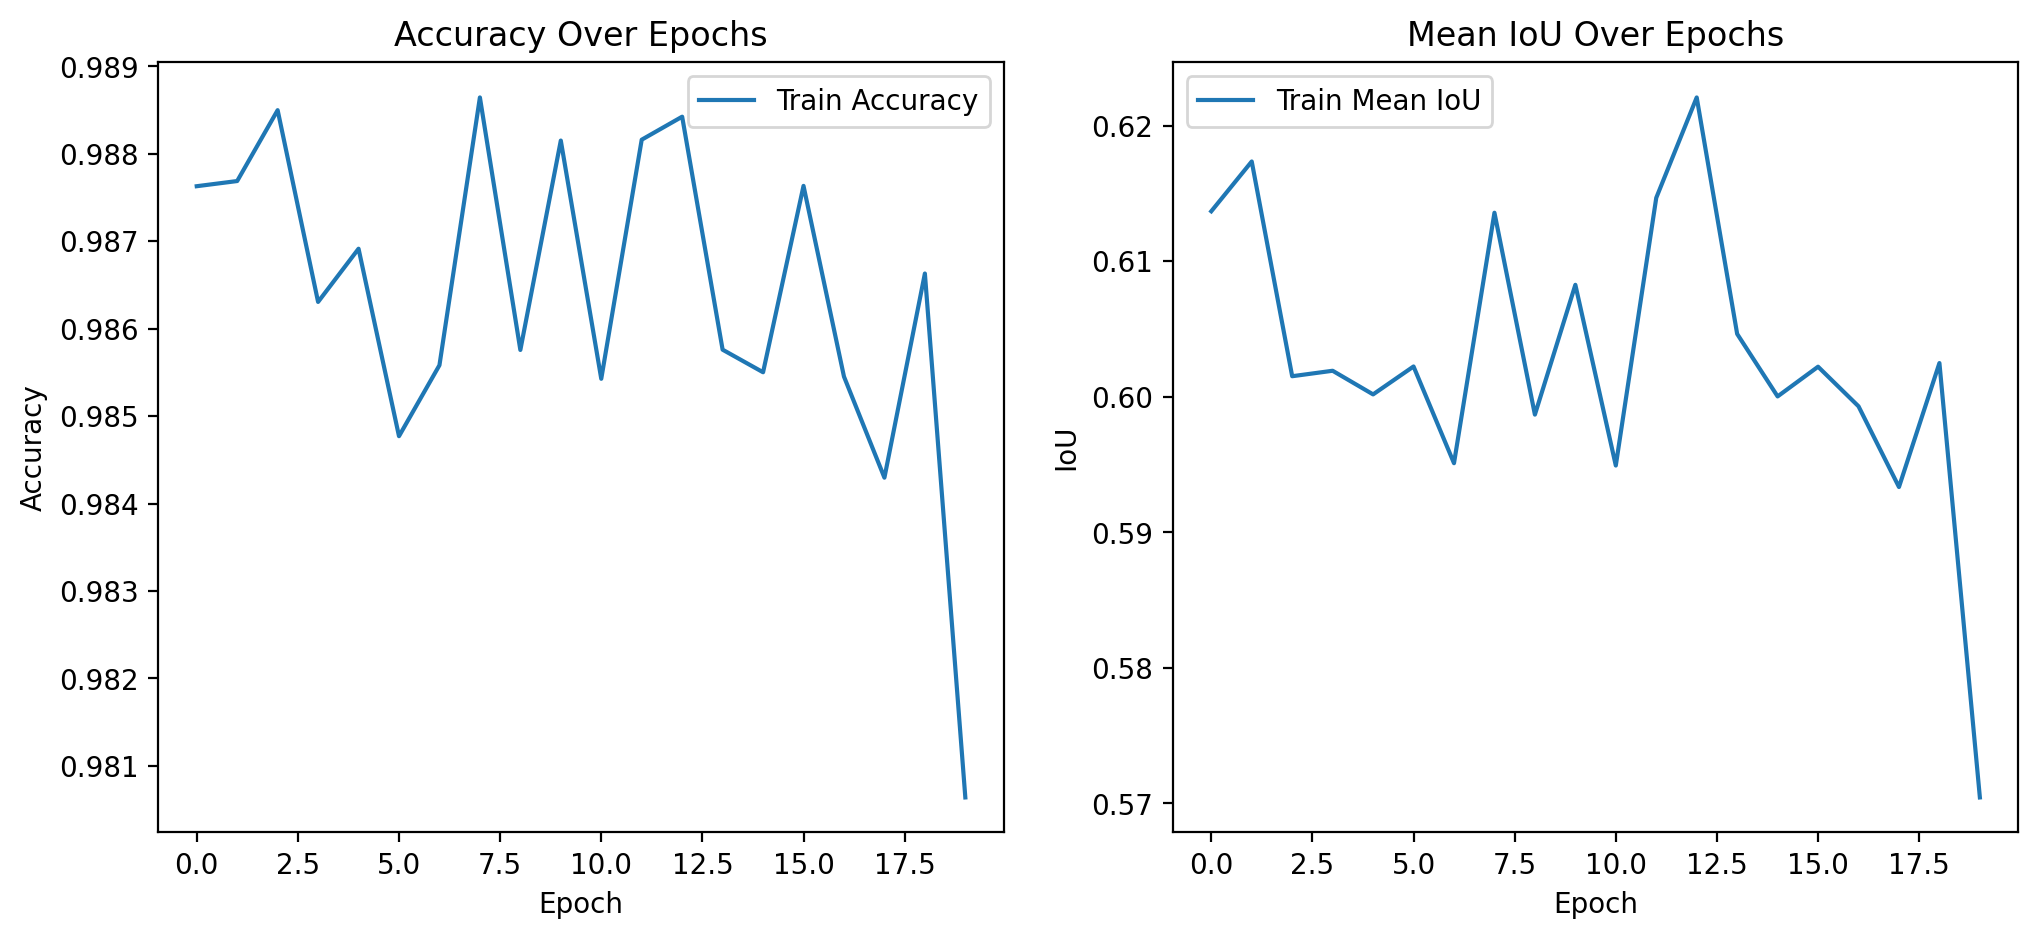

In [28]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mean_iou'], label='Train Mean IoU')
plt.title("Mean IoU Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()

plt.show()

In [5]:
unet = tf.keras.models.load_model("unet_model", custom_objects={'OneHotMeanIoU': lambda **kwargs: OneHotMeanIoU(num_classes=2, **kwargs)})

In [7]:
Nt = 100 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

x_test = []
x_p = []
y_test = []

for i in range(0, Nt):
    # 当前帧 shape (256,256,1)
    curr = tf.expand_dims(vid[i],   axis=-1)
    pre = tf.expand_dims(vid[i-1], axis=-1)
    
    x_test.append(curr)
    x_p.append(pre)
    
    y_test.append(labels[i])  # 对应当前帧的标签

x_test = tf.stack(x_test, axis=0)  # (Nt-1, 256,256,1)
x_p = tf.stack(x_p, axis=0)  # (Nt-1, 256,256,1)
y_test = tf.stack(y_test, axis=0)

In [ ]:
predictions = unet.predict(x_test)
@interact(t=(0, Nt-2, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(131)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)

    fig.add_subplot(132)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')

    fig.add_subplot(133)
    imshow(vid[t], origin='lower')
    imshow(predictions[t, ..., 1], origin='lower')

4/4 [==============================] - 5s 1s/step


interactive(children=(IntSlider(value=0, description='t', max=98), Checkbox(value=True, description='show_trac…